# Disparity Map (Depth Map) from Stereo Vision Images

### Dataset
Dataset from Middlebury: http://vision.middlebury.edu/stereo/data/

Dataset from Kitti: https://www.cvlibs.net/datasets/kitti/eval_stereo_flow.php?benchmark=stereo

The datasets used here are already rectified.

#### Reference:
- https://www.baeldung.com/cs/disparity-map-stereo-vision
- https://johnwlambert.github.io/stereo/#first-algorithm

#### Disparity Map
- Stereo vision has 2 visions (e.g. one from left and another from right).
- Image captured from the left camera and the image captured from the right camera have disparity (difference in the position).
- Further the object is from the camera, smaller the disparity. Closer the object is from the camera, greater the disparity.
- Disparity map makes the pixels brighter if there is more disparity. --> In other words, brighter pixels for closer objects. --> Disparity map captures the objects' relative positions.

#### Algorithm Steps
- Image Rectiication: Usually, you first simplify the problem by rectifying the stereo images. After rectification, the corresponding points will lie on the same horizontal line. --> Reduces the 2D stere0 correspondence problem to a 1D problem --> There will be disparity along only one axis (x-axis in this case).
  - 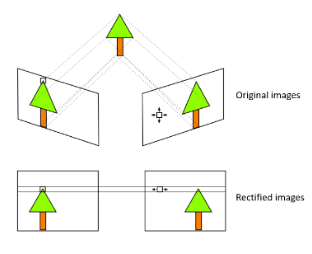
- Block (Window; Kernel) Matching
  - 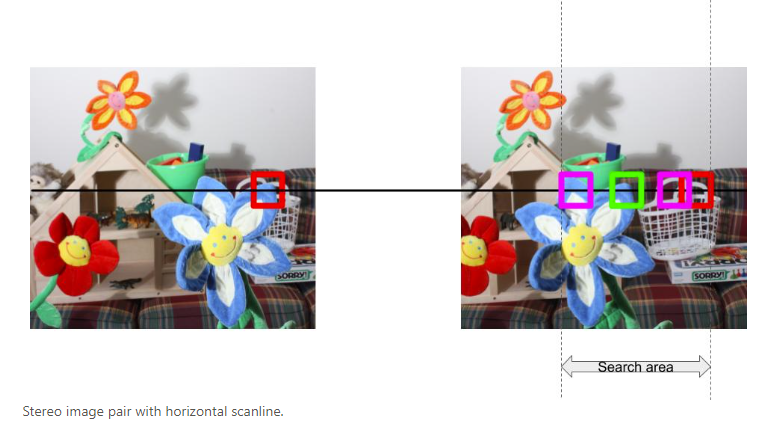
  - 
  - 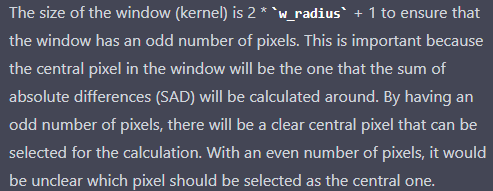
- SAD (Sum of Absolute Differences): The SAD is the sum of the absolute differences between the corresponding pixels in the two images.
  - 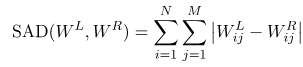
  - 
   

### Set up

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import time

from tqdm import tqdm
from PIL import Image

import cv2

In [2]:
# image location
left_img_loc = 'D:/Personal DL Projects/Disparity_Map_with_Stereo_Vision/rectified_images/left_images/'
right_img_loc = 'D:/Personal DL Projects/Disparity_Map_with_Stereo_Vision/rectified_images/right_images/'

# image count
img_count = len(os.listdir(left_img_loc))

### Display Images from Dataset

100%|██████████| 8/8 [00:00<00:00, 19.26it/s]
C:\Users\whdqk\AppData\Local\Temp\ipykernel_44008\189654660.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  left_images = np.array(left_images)
100%|██████████| 8/8 [00:00<00:00, 20.08it/s]
C:\Users\whdqk\AppData\Local\Temp\ipykernel_44008\189654660.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  right_images = np.array(right_images)


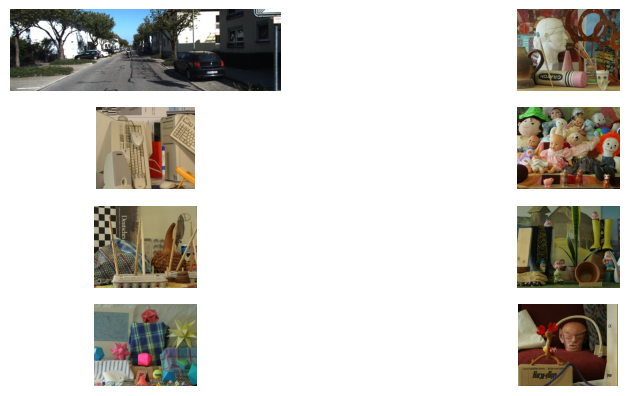

In [3]:
left_images = []
# left_images = [np.zeros((480, 640, 3))] # initialize with fake big size image to prevent error while appending
for img_file in tqdm(os.listdir(left_img_loc)[:img_count]):
    pic = Image.open(left_img_loc + img_file)
    left_images.append(np.uint8(pic))
left_images = np.array(left_images)

right_images = []
# right_images = [np.zeros((480, 640, 3))] # intialize with fake big size image to prevent error while appending
for img_file in tqdm(os.listdir(right_img_loc)[:img_count]):
    pic = Image.open(right_img_loc + img_file)
    right_images.append(np.uint8(pic))
right_images = np.array(right_images)

total_images = np.hstack((left_images, right_images))

plt.figure(1, figsize=(10,10))
for i in range(img_count):
    plt.subplot(img_count, 2, i+1)
    plt.imshow(total_images[i])
    plt.axis('off') # make the increment marks on the axes invisible
plt.show()

### Convert RGB Images to Grayscale

C:\Users\whdqk\AppData\Local\Temp\ipykernel_44008\1841818808.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  left_images_gray = np.array(left_images_gray)
C:\Users\whdqk\AppData\Local\Temp\ipykernel_44008\1841818808.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  right_images_gray = np.array(right_images_gray)


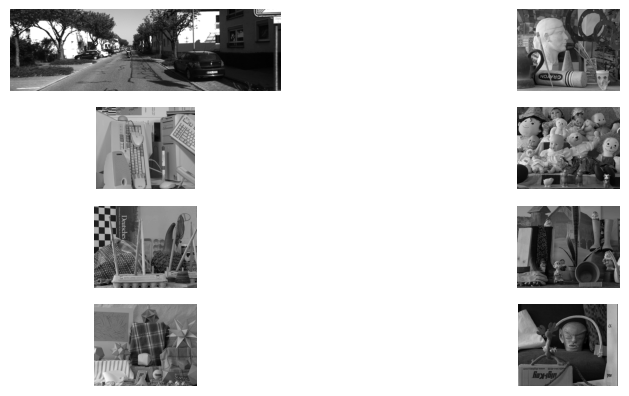

In [4]:
left_images_gray = []
for img_file in left_images:
    pic_gray = np.mean(img_file, axis=2).astype(np.uint8)
    left_images_gray.append(pic_gray)
left_images_gray = np.array(left_images_gray)

right_images_gray = []
for img_file in right_images:
    pic_gray = np.mean(img_file, axis=2).astype(np.uint8)
    right_images_gray.append(pic_gray)
right_images_gray = np.array(right_images_gray)

total_images_gray = np.hstack((left_images_gray, right_images_gray))

plt.figure(1, figsize=(10,10))
for i in range(img_count):
    plt.subplot(img_count, 2, i+1)
    plt.imshow(total_images_gray[i], cmap = plt.cm.gray)
    plt.axis('off') # make the increment marks on the axes invisible
plt.show()

### Generate Disparity Map (Depth Map)

In [5]:
# hyperparameters
min_d = 0 # minimum disparity to slide the window in the right image per center pixel of the window in the left image
max_d = 64 # maximum disparity to slide the window in the right image per center pixel of the window in the left image
w_radius = 4 # window radius (window size = 2*w_radius + 1)

In [6]:
disparity_map_lists = [] # list to store disparity maps

## Through out the images
for left_img, right_img in zip(left_images_gray, right_images_gray):

    ## Convert images to double
    # The reason for converting the images to double is to ensure that the calculations performed on the images have high precision.
    left_img = np.double(left_img) # convert to double
    right_img = np.double(right_img) # convert to double

    ## Initialize variables
    height, width = left_img.shape # height (row) and width (col) of the image
    search_area = np.arange(min_d, max_d+1) # search area (disparity range) for disparity in the right image
    disparity_map = np.zeros((height, width)) # preallocatin of disparity map

    ## Through out the width of the image
    for i in tqdm(range(1+w_radius, height-w_radius)):

        ## Through out the height of the image
        for j in range(1+w_radius+max_d, width-w_radius-max_d):
            window_left = left_img[i-w_radius:i+w_radius, j-w_radius:j+w_radius] # window in the left image
            best_SAD = np.inf # initialize best SAD (Sum of Absolute Differences)
            best_d = min_d # initalize best disparity

            ## Through out the search area (disparity range)
            for d in search_area:
                window_right = right_img[i-w_radius:i+w_radius, j-w_radius-d:j+w_radius-d] # window in the right image
                SAD = np.sum(np.abs(window_left - window_right)) # calculate SAD

                ## If the SAD is less than the best SAD
                if SAD < best_SAD:
                    best_SAD = SAD # update the SAD
                    best_d = d # update the best disparity

            disparity_map[i, j] = best_d # update each pixel of the disparity map w/ the best disparity

    disparity_map_lists.append(disparity_map) # append the disparity map to the list


100%|██████████| 1101/1101 [14:08<00:00,  1.30it/s]


### Display Disparity Maps
Brighter pixel the closer the it is from the stereo camera.
- the disparity (position difference) of the objects in the left image and the right image is smaller.
- has a smaller SAD (Sum of Absolute Differences).
- the disparity value becomes the pixel value of the disparity map.
- Summary:
  - Object is closer to the stereo camera --> smaller SAD --> smaller disparity (difference) between the pixels in the left and right images --> smaller disparity becomes the value of the corresponding pixel in the disparity map --> smaller value means the color is lighter --> lighter pixel means it is closer to the stereo camera

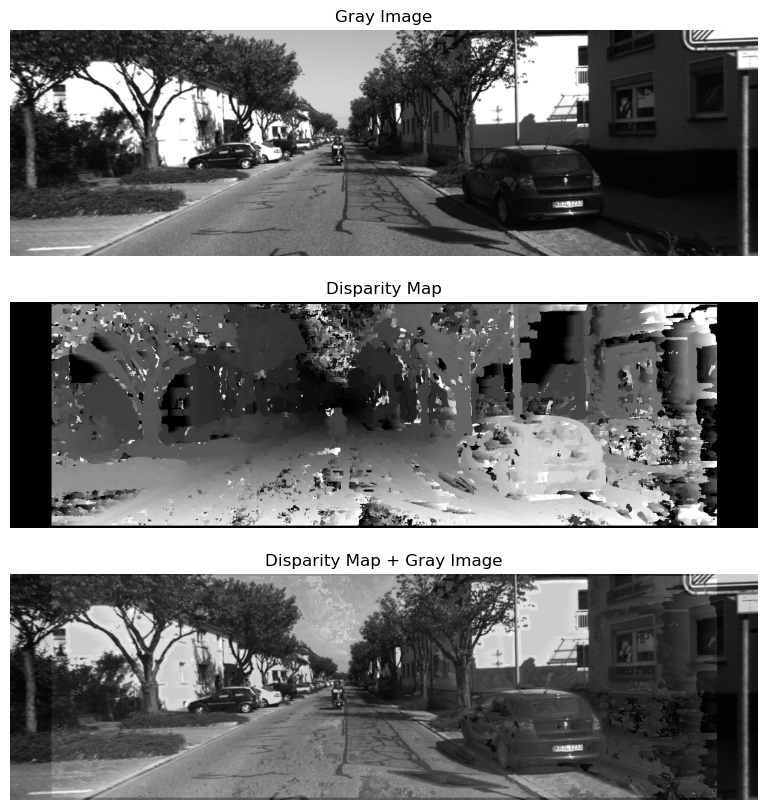

<Figure size 640x480 with 0 Axes>

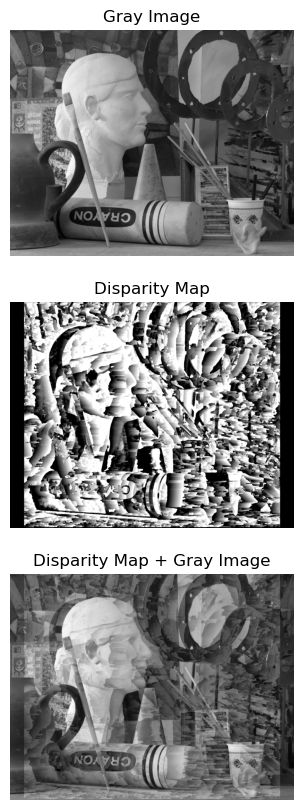

<Figure size 640x480 with 0 Axes>

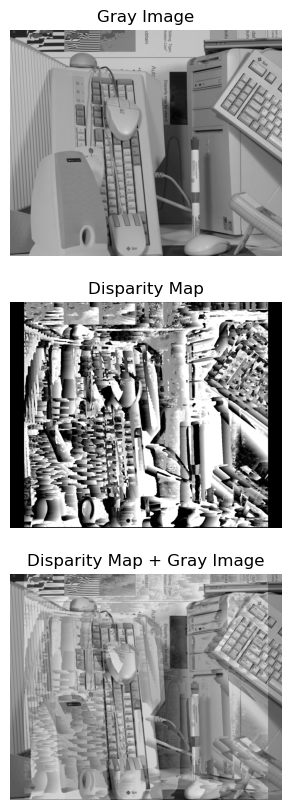

<Figure size 640x480 with 0 Axes>

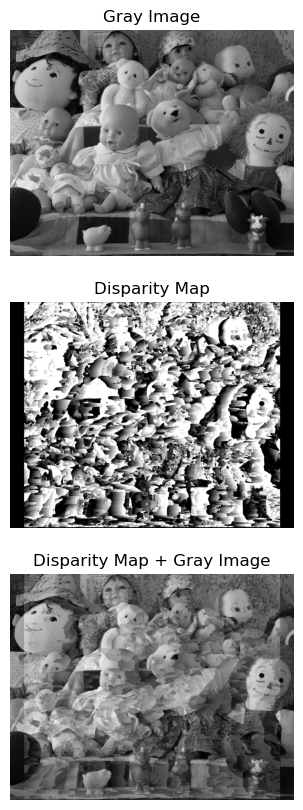

<Figure size 640x480 with 0 Axes>

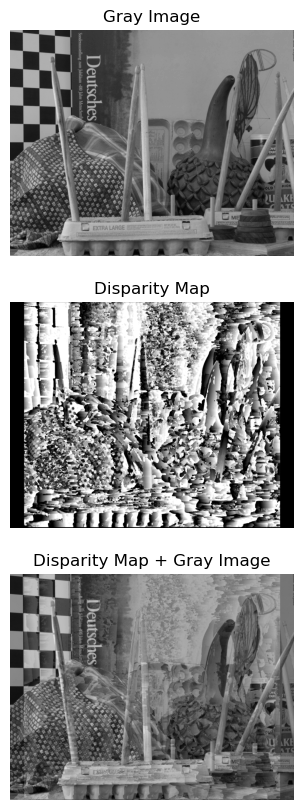

<Figure size 640x480 with 0 Axes>

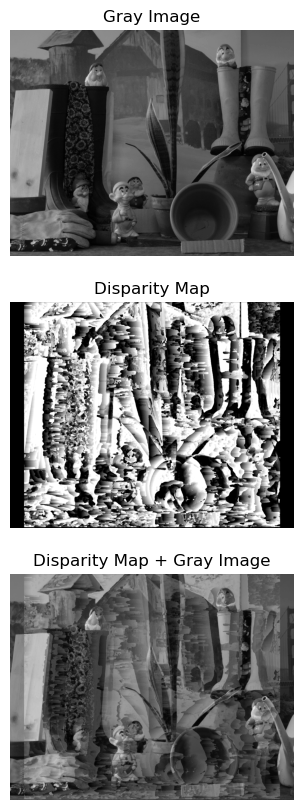

<Figure size 640x480 with 0 Axes>

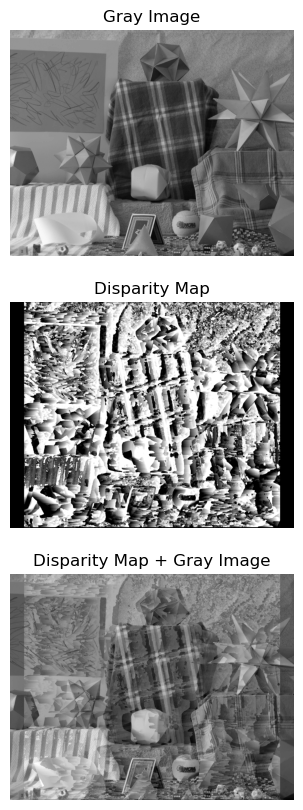

<Figure size 640x480 with 0 Axes>

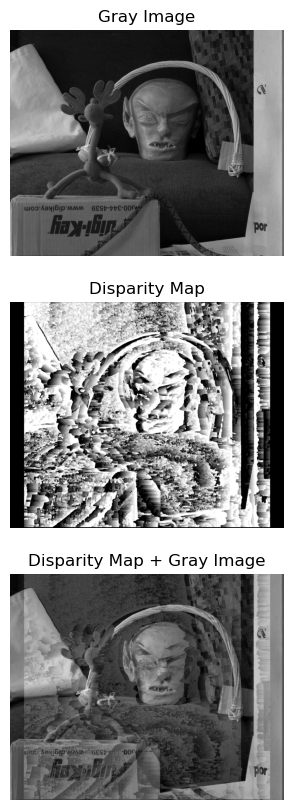

<Figure size 640x480 with 0 Axes>

In [20]:
for i in range(len(disparity_map_lists)):
    # plot
    plt.figure(i+1, figsize=(10,10))

    plt.subplot(3,1, 1)
    plt.title("Gray Image")
    plt.imshow(left_images_gray[i], cmap = plt.cm.gray)
    plt.axis('off') # make the increment marks on the axes invisible

    plt.subplot(3,1, 2)
    plt.title("Disparity Map")
    plt.imshow(disparity_map_lists[i], vmin=0, vmax=max_d, cmap='gray') # vmin and vmax are used to set the color limits. Outliers will be clipped.
    plt.axis('off') # make the increment marks on the axes invisible

    plt.subplot(3,1, 3)
    plt.title("Disparity Map + Gray Image")
    plt.imshow(disparity_map_lists[i] + left_images_gray[i], cmap='gray')
    plt.axis('off') # make the increment marks on the axes invisible

    plt.show()
